In [56]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error
from sklearn.linear_model import LogisticRegression, ElasticNet

# Métricas para clasificación

Como ya hemos visto en los problemas de clasificación la métrica que se usa por defecto a la hora de ver lo bien que se comporta un determinado modelo es la precisión (accuracy). Sin embargo existen determinadas situaciones en las que hacer uso de esta medida no es una buena idea. Supongamos el caso en el cual estamos haciendo uso de un clasificador de spam donde tenemos que el 99% de nuestro emails son útiles y tan solo el 1% es spam. En este caso, si cada vez que llegase un correo el modelo dijese que es el correo no es spam tendría una precisión del 99% pero en absoluto haría lo que queremos, que es detectar los correos que son spam. Para este tipo de casos podemos hacer uso de la matriz de confusión y a partir de esta obtener las medidas de : accuracy, precision, recall y support. La precision se define como el cociente entre tp/(tp+fp), supongamos que estamos intentando identificar perros y  gatos en una imagen. En esta imagen tenemos un total de 12 perros y el resto son gatos. Supongamos que nuestro algoritmo clasifica como perros a 8 elementos, de estos 8 elementos 5 son verdaderamente perros los otros 3 son gatos entonces nuestra precision = 5/(5+3) = 5/8. Por otro lado el recall se define como tp/(tp+fn), en nuestro ejemplo nuestra recall sería 5/(5+7) = 5/12. En el siguiente problema vamos a tratar con el conjunto de datos diabetes.csv, que vamos a tratar de clasificar a gente como diabética o no diabética en función de una serie de características.

In [44]:
#Cargamos los datos 
df = pd.read_csv('diabetes.csv')
x = df.drop('diabetes', axis = 1)
y = df['diabetes']
#Dibimos entre train y test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 42)
#Cremos nuestro clasificador knn con k = 6
knn = KNeighborsClassifier(n_neighbors = 6)
#Fijamos el predictor
knn.fit(x_train, y_train)
#Predecimos
y_pred = knn.predict(x_test)
#Generamos la matriz de confusión y sus métricas
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[176  30]
 [ 56  46]]
             precision    recall  f1-score   support

          0       0.76      0.85      0.80       206
          1       0.61      0.45      0.52       102

avg / total       0.71      0.72      0.71       308



La métrica support nos indica el número de muestras que hemos clasificado bien como personas con diabetes y no diabetes.

# Métrica Logloss

La métrica logloss cuantifica la precisión de un clasificador al penalizar las clasificaciones falsas. Supongamos la situación donde estamos intentando predecir si un email es spam o no. El 99% de nuestros emails no serán spam y el 1% serán spam, ya sabemos que hacer uso de accuracy como métrica no es adecuado, logloss lo que hace es penalizar fuertemente aquellas situaciones en las que el email se clasifico como spam si este no lo era y viceversa. Es decir, en los casos que el clasificador asigna una probabilidad muy pequeña a la clase correcta, su contribución a la medida logloss será muy grande. Para calcular esta métrica podemos hacer uso de la siguiente función

In [1]:
def compute_log_loss(predicted, actual, eps = 1e-14):
    '''Calcula la métrica logloss entre el valor predicho y el actual cuando estos son
    un array 1D'''
    predicted = np.clip(predicted, eps, 1 - eps)
    loss = -1 * np.mean(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))
    return loss

# Regresión Logística y Curva ROC

La regresión logística pese a su nombre se trata de un algoritmo usado para problemas de clasificación. Se trata de un método que puede ser usado en los problemas de clasificació binaria. Sobre todon en aquellos casos en los que ponemos un umbra de probabilidad entre un tipo u otro. Por ejemplo para un probabilidad superior a 0.7 consideramos 0 y para una probabilidad inferior consideramos 1. A continuación haremos uso de la regresión logística para el caso de diabetes y veremos si consigue mejores resultados que nuestro algoritmo knn.

In [36]:
#Separamos en train y test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state=42)
#Nos creamos nuestro regresor logístico
reg_log = LogisticRegression()
#Fijamos el regresor
reg_log.fit(x_train, y_train)
#Predecimos
y_pred = reg_log.predict(x_test)
#Visualizamos nuestra matriz de confusión y sus métricas
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[174  32]
 [ 36  66]]
             precision    recall  f1-score   support

          0       0.83      0.84      0.84       206
          1       0.67      0.65      0.66       102

avg / total       0.78      0.78      0.78       308



Classification_reports y la matriz de confusión son una buena forma de evaluar cuantitativamente el rendimiento de un modelo, mientras que la curva ROC nos proporciona una forma más visual de evaluar un modelo. El método predict.proba(), nos devuelve la probabilidad de que un determinado ejemplo pertenezca a una clase, este método está incorporado en muchos clasificadores. 

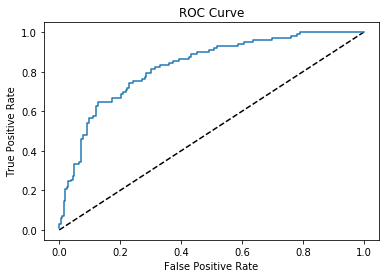

In [45]:
#Computamos la probabilidad de que nuestras predicciones pertenezcan a una determinada clase
y_pred_prob = reg_log.predict_proba(x_test)[:, 1]
#Generamos los valores de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
#Mostramos la curva ROC
_ = plt.plot([0,1], [0, 1], 'k--')
_ = plt.plot(fpr, tpr, label = 'Logistic Regression')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
plt.show()

El área bajo esta curva, se trata de una de las métricas más populares a la hora de evaluar un modelo de clasificación. Un  modelo con un área bajo la curva ROC de 1 indicaría un modelo perfecto, cuanto más elevada sea este área mejor sera capaz nuestro modelo de clasificar de formar correcta nuestro problema binario. A continuación vamos a calcular el área bajo la curva ROC para nuestro conjunto de datos diabetes.csv, realizando un 5-fold cross validation.

In [38]:
y_pred_prob = reg_log.predict_proba(x_test)[:, 1]
#Obtenemos el área bajo la curva roc
print('AUC: {}'.format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.8269084332762231


In [39]:
#Ahora obtenemos el área bajo la curva ROC pero haciendo uso de 5-fold
cv_auc = cross_val_score(reg_log, x, y, cv = 5, scoring = 'roc_auc')
print('AUC {}'.format(cv_auc))

AUC [ 0.7987037   0.80777778  0.81962963  0.86584906  0.85037736]


# Hyperparameter tuning

A la hora de elegir los parámetros que mejor resultado nos proporciona un modelo, python nos proporiciona la opción de realizar un tuning de parámetros. Para comprender esto mejor, vamos a realizar un ejemplo para el caso del dataset diabetes.csv, donde vamos a tratar de encontrar el mejor parámetro C, que nos controla que el modelo no este overfitting o underfitting. En este caso no vamos a dividir los datos en train y test, ya que únicamente nos queremos centrar en el tuning de parámetros.

In [46]:
#Nos creamos nuestro grid de parámetros para nuestro parámetro C
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(x, y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameters: {'C': 268.26957952797272}
Best score is 0.7708333333333334


Realizar un GridSearchCV puede ser computacionalmente bastante costoso, especialmente si estamos buscando un gran espacio de hiperparámetro y manejando múltiples hiperparámetros. Una solución a esto es el uso de RandomizedSearchCV, que no prueba todos los valores posibles para el hiperparámetro. En su lugar, se fijan un número fijo de hiperparámetros a partir de distribuciones de probabilidad configuradas. Para ver su potencial, vamos a hacer uso de un nuevo modelo los árboles de decisión. Para un árbol de decisión el número de parámetros que necesitamos optimos que necesitamos encontrar es bastante elevado: max_features, max_depth, min_samples_leaf.

In [51]:
#Nos creamos nuestra distribución de parámetros
param_dist = {'max_depth': [3,None],
             'max_features': randint(1,9),
             'min_samples_leaf': randint(1,9),
             'criterion': ['gini', 'entropy']}
#Inicializamos nuestro decision tree
tree = DecisionTreeClassifier()
#Hacemos nuestro tuning de parámetros
tree_cv = RandomizedSearchCV(tree, param_dist, cv = 5)
#Hacemos el fit
tree_cv.fit(x,y)
#Mostramos los resultados
print('Los parámetros óptimos son: {}'.format(tree_cv.best_params_))
print('El mejor resultado es: {}'.format(tree_cv.best_score_))

Los parámetros óptimos son: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 1}
El mejor resultado es: 0.7395833333333334


Debemos tener claro que RandomizedSearchCV nunca superará a GridSearchCV, pero en numerosas ocasiones es utilizado ya que computacionalmente es menos costoso.

Hasta ahora hemos hecho uso de del tuning de parámetros sin realizar conjunto de train&test, esto no es lo ideal. Lo ideal es finalmente tener un conjunto de datos que nuestro algoritmo no haya visto, para ver si nuestro algoritmo está generalizando de forma adecuada.

La regresión logística además del hiperparámetro C dispone del hiperparámetro penalty que nos indica si debemos de hacer uso de la regularización L1 O L2. A continuación vamos a proceder a realizar un tuning de parámetros.

In [54]:
#Nos creamos nuestro grid de parámetros
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}
#Hacemos nuestra partición en train y test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 42)
#Nos creamos nuestro regresor logístico
logreg = LogisticRegression()
#Nos creamos nuestro 5-flod
logreg_cv = GridSearchCV(logreg, param_grid, cv = 5)
#Hacemos un fit
logreg_cv.fit(x_train, y_train)
#Mostramos los resultados por pantalla
print('Los mejores parámetros son: {}'.format(logreg_cv.best_params_))
print('El mejor resultado en términos de accuracy es: {}'.format(logreg_cv.best_score_))

Los mejores parámetros son: {'penalty': 'l2', 'C': 31.622776601683793}
El mejor resultado en términos de accuracy es: 0.7673913043478261


Como ya vimos a la hora de regularizar la regresión de Lasso hacía uso de la penalización L1 mientras que la regresión de Ridge hace uso de la penalización L2. Existe otro tipo de regularización de regresión conocido con red elástica. En la regularización de red elástica, la penalización que se realiza es una combinación lineal de las dos anteriores: a*L1 + b*L2. 
En scikit-learn, este término es conocido como el parámetro l1_ratio. Un l1_ratio de 1 corresponde a una penalización de L1 mientras que cualquier otro valor corresponde a una combinación lineal entre L1 y L2.

In [60]:
#Dividimos nuestro conjunto de entrenamiento en train y test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 42)
#Nos creamos nuestr grid de parámetros
l1_space = np.linspace(0, 1, 100)
param_grid = {'l1_ratio': l1_space}
#Fijamos nuestro regresor elástico
elastic_reg = ElasticNet()
#Computamos nuestro grid
gm_cv = GridSearchCV(elastic_reg, param_grid, cv = 5)
#Hacemos el fit
gm_cv.fit(x_train, y_train)
#Hacemos predicciones
y_pred = gm_cv.predict(x_test)
#Calculamos la métrica R^2 y también el erro cuadrático medio
r2 = gm_cv.score(x_test, y_test)
mse = mean_squared_error(y_test, y_pred)
#Mostramos los resultados por pantalla
print('Parámetros óptimos para el regresor elástico: {}'.format(gm_cv.best_params_))
print('Elastic Net R2: {}'.format(r2))
print('Elastic Net mse: {}'.format(mse))

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

Parámetros óptimos para el regresor elástico: {'l1_ratio': 0.0}
Elastic Net R2: 0.24765337510702687
Elastic Net mse: 0.16664179543611013


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
